# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [129]:
import artm

In [130]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [131]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [146]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", 
                                        target_folder="lectures_batches", batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [147]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, 
                      num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [148]:
# Ваш код
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize("dictionary")

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [149]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [150]:
# Ваш код
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SmoothPhi', 
        tau=1e5, 
        dictionary=dictionary, 
        class_ids=['text'], 
        topic_names="bcg"))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [151]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [152]:
# Ваш код
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SparsePhi', 
        tau=-1e5, 
        dictionary=dictionary, 
        class_ids=['text'], 
        topic_names=topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [153]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [154]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print
    
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_author"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  церковь власть русь средневековый император святой римский сага князь папа король александр византийский церковный рим
sbj1:  планета земля атмосфера солнце солнечный белый газ карлик образовываться вокруг звезда спутник вода поверхность кислород
sbj2:  система состояние трудность двигаться частота поведение искусственный точность относительность движение переход тест час самка самец
sbj3:  культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство переживание повседневный этика лосев глобальный
sbj4:  право литература литературный искусство юрист должник собственность обязательство римский владение произведение писатель юридический собственник исполнение
sbj5:  материал структура молекула свойство углерод применение полимер поверхность вещество кристалл металл электронный алмаз углеродный твердый
sbj6:  фильм книга автор кино театр жанр кинематограф анекдот тема документ пьеса культовый академия герой екатерина
sbj7:  смерть ритуал террор гос

sbj17:  Алексей_Козырев Иван_Болдырев Владимир_Малахов Дина_Гусейнова Александр_Павлов Петр_Резвых Павел_Соколов Василий_Жарков Дмитрий_Балалыкин Валентина_Харитонова Руслан_Хестанов Александр_Воеводский Николай_Плотников Анна_Севортьян Юрий_Рогулёв
sbj18:  Александр_Пиперски Светлана_Евграфова Дмитрий_Добровольский Борис_Иомдин Анатолий_Баранов Надежда_Онипенко Петр_Аркадьев Алексей_Шмелев Леонид_Иомдин Андрей_Кибрик Владимир_Плунгян Екатерина_Протасова Екатерина_Лютикова Вера_Подлесская Анастасия_Лопухина
sbj19:  Дмитрий_Бовыкин Андрей_Зорин Борис_Колоницкий Раиса_Кирсанова Вера_Мильчина Мария_Майофис Алексей_Миллер Дина_Гусейнова Александр_Дмитриев Максим_Демин Мария_Неклюдова Марина_Новикова-Грунд Илья_Иткин Светлана_Баньковская Михаил_Алексеевский
sbj20:  Александр_Сафонов Алексей_Лебедев Оксана_Запорожец Александр_Тормасов Екатерина_Ларионова Екатерина_Лапина-Кратасюк Руслан_Смелянский Евгений_Магид Джанмарко_Веруджио Лев_Беклемишев Деметрис_Зейналипур Сергей_Карабасов Дарья_Радч

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = [
    u"Религия", #0
    u"Физическая география", #1
    u"Искусственный интеллект",#2
    u"Культурология", #3
    u"Римское право", #4
    u"Оптические материалы", #5
    u"Киносценарий", #6
    u"Ритуалы и обряды", #7
    u"Химия", #8
    u"Физика элементарных частиц", #9
    u"История", #10
    u"Семья", #11
    u"Онкология", #12
    u"Религиоведение", #13
    u"Астрономия", #14
    u"Психология", #15
    u"Социально-экономическая география", #16
    u"Философия", #17
    u"Русский язык", #18
    u"Французская революция", #19
    u"Средства информации", #20
    u"Медицина", #21
    u"Социология", #22
    u"Микроорганизмы", #23
    u"Мифология", #24
    u"Лингвистика", #25
    u"Экономический кризис", #26
    u"Генетика", #27
    u"Сверхпроводники", #28
]   # запишите названия тем в список
topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [157]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
model_artm.cache_theta = True
# Ваш код
theta = model_artm.get_theta()
print(theta.shape)
phi_a = model_artm.get_phi(class_ids=["author"])
print(phi_a.shape)

(30, 1728)
(539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

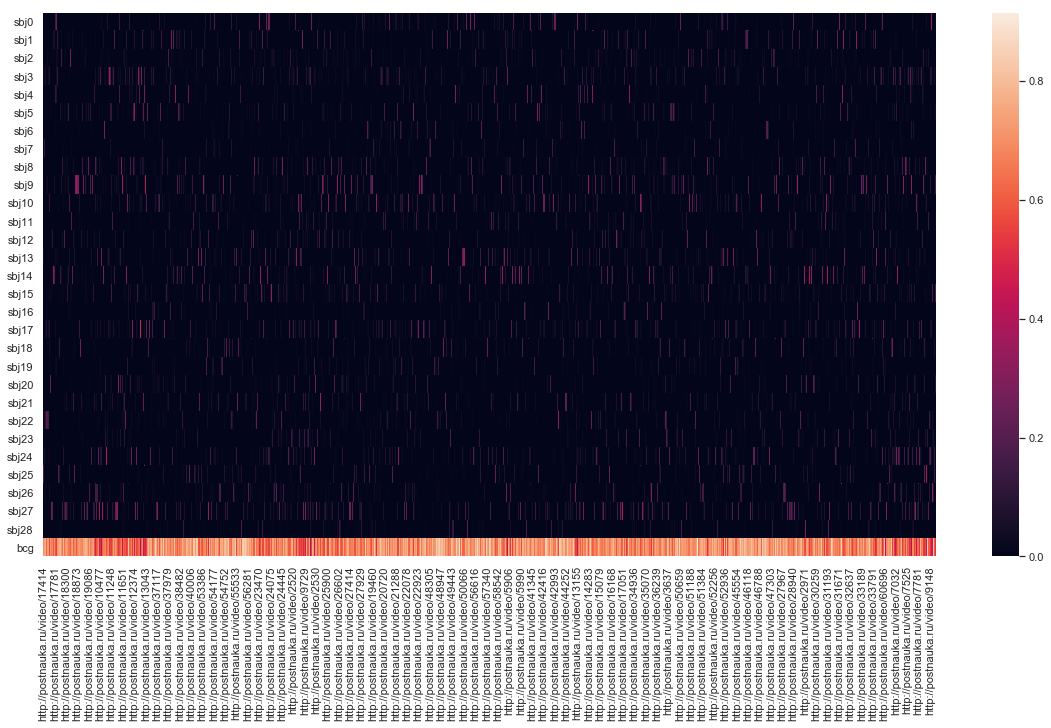

In [163]:
# Ваш код
fig, ax = plt.subplots(figsize=(20, 10))
seaborn.heatmap(theta[:100]);

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [164]:
# Ваш код
p_t = np.sum(theta, axis=1).sort_values()
top_theme_idx = [int(x[3:]) for x in p_t.iloc[-6:-1].index]
bottom_theme_ids = [int(x[3:]) for x in p_t.iloc[0:3].index]

print("Top themes")
for x in top_theme_idx:
    print(repr(topic_labels[x]).decode('unicode_escape'))
print("Bottom themes")
for x in bottom_theme_ids:
    print(repr(topic_labels[x]).decode('unicode_escape'))

Top themes
u'Философия'
u'Мифология'
u'Астрономия'
u'Физика элементарных частиц'
u'Генетика'
Bottom themes
u'Социально-экономическая география'
u'Ритуалы и обряды'
u'Сверхпроводники'


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

(539, 30)


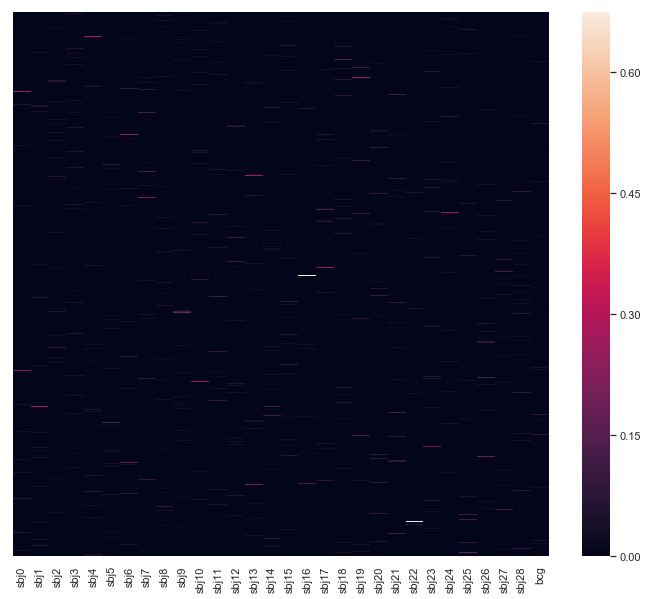

In [166]:
# Ваш код
print(phi_a.shape)
seaborn.set(rc={'figure.figsize':(12,10)})
seaborn.heatmap(phi_a, yticklabels=False);

In [167]:
np.sum(phi_authors > 0.01, axis=1).sort_values(ascending=False)[0:10]

(author, Михаил_Алексеевский)     4
(author, Дмитрий_Бовыкин)         3
(author, Елена_Брызгалина)        3
(author, Елена_Браун)             3
(author, Алексей_Акимов)          2
(author, Наталья_Кисельникова)    2
(author, Екатерина_Щербакова)     2
(author, Наталья_Спасская)        2
(author, Мария_Майофис)           2
(author, Раиса_Кирсанова)         2
dtype: int64

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [168]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [169]:
# Ваш код
pt_a_ = phi_authors * p_t
pt_a = pt_a_ / np.sum(pt_a_, axis=0)
X_embedded = MDS(n_components=2, dissimilarity='precomputed')
MDS_transformed = X_embedded.fit_transform(pairwise_distances(pt_a, metric='cosine'))
MDS_transformed.shape

(539, 2)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

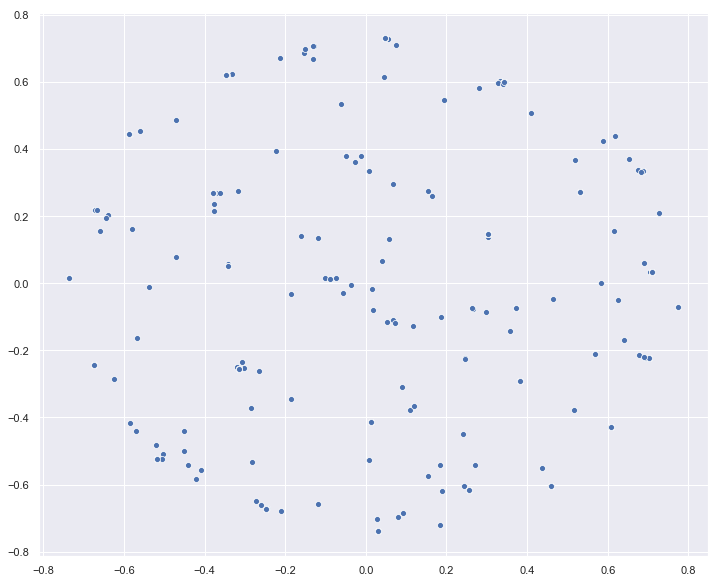

In [170]:
# Ваш код
seaborn.scatterplot(MDS_transformed[:, 0], MDS_transformed[:, 1]);

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

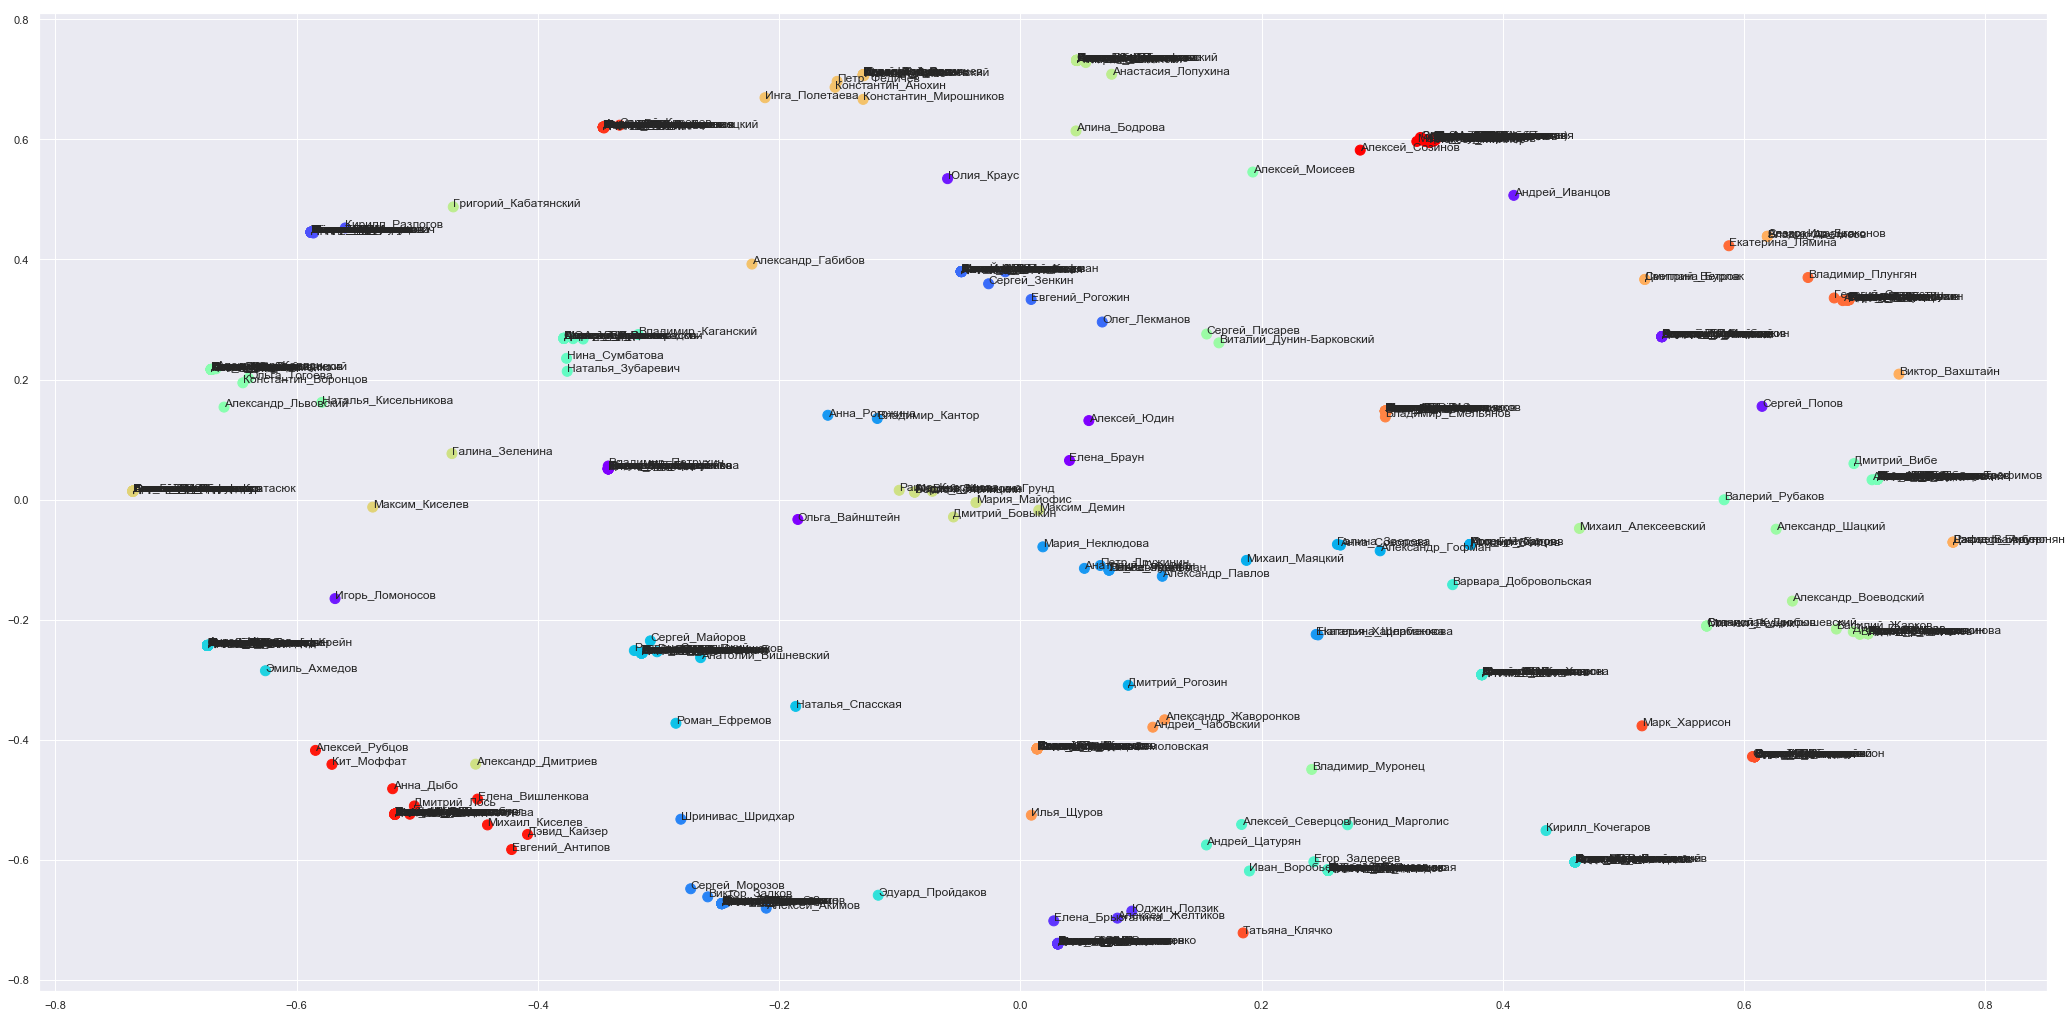

In [171]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
color_labels = [x[1].idxmax() for x in phi_authors.iterrows()]
color_labels = [29 if x=='bcg' else int(x[3:]) for x in color_labels]
palette = [colors[x] for x in color_labels]

fig, ax = plt.subplots(figsize=(36, 18))
plt.scatter(x=MDS_transformed[:, 0], y=MDS_transformed[:, 1], c=palette, s=100);

for i in range(len(MDS_transformed)):
    plt.annotate(phi_authors.index[i][1], xy=MDS_transformed[i])

fig.savefig("postnauka.pdf", bbox_inches='tight')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [172]:
# Ваш код
rows_sum = np.sum(theta, axis=1)
pdt = [theta.iloc[i, :]/rows_sum[i] for i in range(len(theta))]
rel_themes = np.argmax(pdt, axis=1)
rel_themes

array([1585,  319,   53,  129,   27, 1043,  279,   68,   33,  198, 1157,
        724, 1110,  302, 1641,  442, 1552,  189, 1202,  325, 1047,  537,
        124, 1540,  123, 1710, 1545,  904, 1476, 1267])

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [173]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [174]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [175]:
# Ваш код
for i in range(len(sbj_topic_labels)):
    display(HTML(u"<h1>" + topic_labels[i] + "</h1>"))
    
    tokens = model_artm.score_tracker["top_words"].last_tokens
    print(" ".join(tokens["sbj" + str(i)]))
    print
    
    for idx in pdt[i].sort_values(ascending=False)[0:10].index:
        print(idx)

церковь власть русь средневековый император святой римский сага князь папа король александр византийский церковный рим

http://postnauka.ru/video/3348
http://postnauka.ru/video/9299
http://postnauka.ru/video/24030
http://postnauka.ru/video/23472
http://postnauka.ru/video/24034
http://postnauka.ru/video/31677
http://postnauka.ru/video/50350
http://postnauka.ru/video/13156
http://postnauka.ru/video/9968
http://postnauka.ru/video/50668


планета земля атмосфера солнце солнечный белый газ карлик образовываться вокруг звезда спутник вода поверхность кислород

http://postnauka.ru/video/53693
http://postnauka.ru/video/31695
http://postnauka.ru/video/32889
http://postnauka.ru/video/51364
http://postnauka.ru/video/9835
http://postnauka.ru/video/36249
http://postnauka.ru/video/9690
http://postnauka.ru/video/49261
http://postnauka.ru/video/37994
http://postnauka.ru/video/24245


система состояние трудность двигаться частота поведение искусственный точность относительность движение переход тест час самка самец

http://postnauka.ru/video/1856
http://postnauka.ru/video/51174
http://postnauka.ru/video/52553
http://postnauka.ru/video/34426
http://postnauka.ru/video/19509
http://postnauka.ru/video/52548
http://postnauka.ru/video/21662
http://postnauka.ru/video/37982
http://postnauka.ru/video/51382
http://postnauka.ru/video/41348


культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство переживание повседневный этика лосев глобальный

http://postnauka.ru/video/11034
http://postnauka.ru/video/12524
http://postnauka.ru/video/12740
http://postnauka.ru/video/5891
http://postnauka.ru/video/7747
http://postnauka.ru/video/11626
http://postnauka.ru/video/7731
http://postnauka.ru/video/7770
http://postnauka.ru/video/20388
http://postnauka.ru/video/10749


право литература литературный искусство юрист должник собственность обязательство римский владение произведение писатель юридический собственник исполнение

http://postnauka.ru/video/17913
http://postnauka.ru/video/31688
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/14297
http://postnauka.ru/video/17825
http://postnauka.ru/video/16822
http://postnauka.ru/video/13042
http://postnauka.ru/video/36715


материал структура молекула свойство углерод применение полимер поверхность вещество кристалл металл электронный алмаз углеродный твердый

http://postnauka.ru/video/13544
http://postnauka.ru/video/12375
http://postnauka.ru/video/41686
http://postnauka.ru/video/31182
http://postnauka.ru/video/22592
http://postnauka.ru/video/36492
http://postnauka.ru/video/46379
http://postnauka.ru/video/36657
http://postnauka.ru/video/47818
http://postnauka.ru/video/36490


фильм книга автор кино театр жанр кинематограф анекдот тема документ пьеса культовый академия герой екатерина

http://postnauka.ru/video/39723
http://postnauka.ru/video/10759
http://postnauka.ru/video/13541
http://postnauka.ru/video/38510
http://postnauka.ru/video/52416
http://postnauka.ru/video/42807
http://postnauka.ru/video/47204
http://postnauka.ru/video/57127
http://postnauka.ru/video/47208
http://postnauka.ru/video/23470


смерть ритуал террор государь правитель обряд идеология служба конвент символический диктатура монтаньяр баратынский подданный биоэтика

http://postnauka.ru/video/1893
http://postnauka.ru/video/48480
http://postnauka.ru/video/32882
http://postnauka.ru/video/37992
http://postnauka.ru/video/12374
http://postnauka.ru/video/50656
http://postnauka.ru/video/16184
http://postnauka.ru/video/48335
http://postnauka.ru/video/1899
http://postnauka.ru/video/51331


метод химический соединение реакция химия давление органический лекарство синтез разработка продукт натрий концентрация природный химик

http://postnauka.ru/video/18048
http://postnauka.ru/video/11646
http://postnauka.ru/video/13700
http://postnauka.ru/video/24449
http://postnauka.ru/video/51490
http://postnauka.ru/video/13151
http://postnauka.ru/video/8953
http://postnauka.ru/video/19071
http://postnauka.ru/video/7363
http://postnauka.ru/video/10473


частица энергия квантовый поле физика взаимодействие атом магнитный электрон кварк теория симметрия фотон элементарный нейтрино

http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/11651
http://postnauka.ru/video/22760
http://postnauka.ru/video/2945
http://postnauka.ru/video/14283
http://postnauka.ru/video/7753
http://postnauka.ru/video/7311
http://postnauka.ru/video/24434


война россия советский русский власть российский германия мировой реформа историк петр немецкий против гражданский военный

http://postnauka.ru/video/35041
http://postnauka.ru/video/19574
http://postnauka.ru/video/46939
http://postnauka.ru/video/31183
http://postnauka.ru/video/29992
http://postnauka.ru/video/51180
http://postnauka.ru/video/26667
http://postnauka.ru/video/42809
http://postnauka.ru/video/25906
http://postnauka.ru/video/41895


ребенок семья возраст взрослый сон мать родитель кровь старение катастрофа конфликт диабет травма стресс сосуд

http://postnauka.ru/video/22892
http://postnauka.ru/video/30678
http://postnauka.ru/video/59638
http://postnauka.ru/video/60527
http://postnauka.ru/video/57657
http://postnauka.ru/video/18613
http://postnauka.ru/video/30606
http://postnauka.ru/video/17395
http://postnauka.ru/video/6377
http://postnauka.ru/video/29103


растение ткань опухоль орган рак иммунный озеро сердце мышца нейронный вода инженерия птица активация печень

http://postnauka.ru/video/16821
http://postnauka.ru/video/23172
http://postnauka.ru/video/46562
http://postnauka.ru/video/13746
http://postnauka.ru/video/51169
http://postnauka.ru/video/51501
http://postnauka.ru/video/33793
http://postnauka.ru/video/18192
http://postnauka.ru/video/26213
http://postnauka.ru/video/17416


территория христианский империя восток народ древний письменность христианство государство памятник цивилизация китай северный восточный китайский

http://postnauka.ru/video/53171
http://postnauka.ru/video/50071
http://postnauka.ru/video/2527
http://postnauka.ru/video/58742
http://postnauka.ru/video/59201
http://postnauka.ru/video/50066
http://postnauka.ru/video/49203
http://postnauka.ru/video/48959
http://postnauka.ru/video/3387
http://postnauka.ru/video/46313


звезда галактика масса вселенная черный свет волна дыра скорость излучение объект вещество расстояние телескоп скопление

http://postnauka.ru/video/6673
http://postnauka.ru/video/17780
http://postnauka.ru/video/31193
http://postnauka.ru/video/2971
http://postnauka.ru/video/29998
http://postnauka.ru/video/23506
http://postnauka.ru/video/30015
http://postnauka.ru/video/23502
http://postnauka.ru/video/57338
http://postnauka.ru/video/48109


задача информация память данные решение компьютер психология мышление внимание когнитивный анализ психологический психолог ошибка компьютерный

http://postnauka.ru/video/24182
http://postnauka.ru/video/24451
http://postnauka.ru/video/5181
http://postnauka.ru/video/23763
http://postnauka.ru/video/53415
http://postnauka.ru/video/19577
http://postnauka.ru/video/56052
http://postnauka.ru/video/57336
http://postnauka.ru/video/50349
http://postnauka.ru/video/17421


раса африка остров америка станислав южный монголоид индия дробышевский нос сенсор штамм индеец территориальный европеоид

http://postnauka.ru/video/31707
http://postnauka.ru/video/32898
http://postnauka.ru/video/49262
http://postnauka.ru/video/42707
http://postnauka.ru/video/37732
http://postnauka.ru/video/42735
http://postnauka.ru/video/35150
http://postnauka.ru/video/17397
http://postnauka.ru/video/40880
http://postnauka.ru/video/36253


политический философия государство общество философский философ партия правовой суд платон мысль враг шмитт политика дух

http://postnauka.ru/video/12738
http://postnauka.ru/video/32906
http://postnauka.ru/video/2526
http://postnauka.ru/video/12371
http://postnauka.ru/video/22975
http://postnauka.ru/video/36713
http://postnauka.ru/video/37965
http://postnauka.ru/video/3418
http://postnauka.ru/video/9728
http://postnauka.ru/video/2972


слово текст русский словарь предложение значение глагол корпус категория лингвистика грамматика конструкция падеж синтаксический устный

http://postnauka.ru/video/36272
http://postnauka.ru/video/6720
http://postnauka.ru/video/1898
http://postnauka.ru/video/48960
http://postnauka.ru/video/47548
http://postnauka.ru/video/51499
http://postnauka.ru/video/56616
http://postnauka.ru/video/2946
http://postnauka.ru/video/57524
http://postnauka.ru/video/30017


революция французский свобода франция роман национальный король нация аргумент актер париж конституция творчество монархия костюм

http://postnauka.ru/video/5396
http://postnauka.ru/video/48492
http://postnauka.ru/video/43843
http://postnauka.ru/video/47823
http://postnauka.ru/video/22079
http://postnauka.ru/video/20720
http://postnauka.ru/video/45548
http://postnauka.ru/video/53577
http://postnauka.ru/video/54742
http://postnauka.ru/video/28944


город сеть робот технология городской интернет компания пользователь музей медиа горожанин библиотека метро управление цифровой

http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/9998
http://postnauka.ru/video/17604
http://postnauka.ru/video/7068
http://postnauka.ru/video/47301
http://postnauka.ru/video/30026
http://postnauka.ru/video/50792
http://postnauka.ru/video/29812


болезнь заболевание пациент лечение врач медицина боль женщина препарат медицинский операция мужчина диагностика больной нарушение

http://postnauka.ru/video/2541
http://postnauka.ru/video/54325
http://postnauka.ru/video/27925
http://postnauka.ru/video/51384
http://postnauka.ru/video/55539
http://postnauka.ru/video/12974
http://postnauka.ru/video/49206
http://postnauka.ru/video/45961
http://postnauka.ru/video/13746
http://postnauka.ru/video/43853


социальный знание социология социологический дисциплина познание перевод социолог описание обучение коммуникация виктор машинный научный высказывание

http://postnauka.ru/video/10783
http://postnauka.ru/video/434
http://postnauka.ru/video/2530
http://postnauka.ru/video/6380
http://postnauka.ru/video/12083
http://postnauka.ru/video/3628
http://postnauka.ru/video/17491
http://postnauka.ru/video/11640
http://postnauka.ru/video/4280
http://postnauka.ru/video/23361


микроорганизм матрица алгоритм эмоция схема вычислительный эмоциональный микроб программный глубина интеллект фольклор машина хищник микробный

http://postnauka.ru/video/31671
http://postnauka.ru/video/49437
http://postnauka.ru/video/3635
http://postnauka.ru/video/42416
http://postnauka.ru/video/34964
http://postnauka.ru/video/3420
http://postnauka.ru/video/52738
http://postnauka.ru/video/33788
http://postnauka.ru/video/3352
http://postnauka.ru/video/2531


исторический бог традиция царь миф греческий представление религия имя мифология эпоха душа религиозный египет андрей

http://postnauka.ru/video/10779
http://postnauka.ru/video/12527
http://postnauka.ru/video/9429
http://postnauka.ru/video/21631
http://postnauka.ru/video/7065
http://postnauka.ru/video/9997
http://postnauka.ru/video/43664
http://postnauka.ru/video/12517
http://postnauka.ru/video/5999
http://postnauka.ru/video/47300


язык лингвист языковой гласный английский согласный лингвистический говор звук диалект филологический компилятор германский программирование жест

http://postnauka.ru/video/8964
http://postnauka.ru/video/13041
http://postnauka.ru/video/10773
http://postnauka.ru/video/48114
http://postnauka.ru/video/51171
http://postnauka.ru/video/15343
http://postnauka.ru/video/16157
http://postnauka.ru/video/14284
http://postnauka.ru/video/57879
http://postnauka.ru/video/7525


страна экономический экономика политика сталин идентичность коллективный кризис общественный праздник принятие выбор ценность прошлое ресурс

http://postnauka.ru/video/31684
http://postnauka.ru/video/9389
http://postnauka.ru/video/3605
http://postnauka.ru/video/30601
http://postnauka.ru/video/7781
http://postnauka.ru/video/13152
http://postnauka.ru/video/5882
http://postnauka.ru/video/6497
http://postnauka.ru/video/28282
http://postnauka.ru/video/56290


клетка ген днк организм белок мозг биологический животное генетический нейрон геном бактерия рнк мутация молекулярный

http://postnauka.ru/video/5915
http://postnauka.ru/video/10475
http://postnauka.ru/video/19436
http://postnauka.ru/video/10754
http://postnauka.ru/video/17051
http://postnauka.ru/video/11628
http://postnauka.ru/video/35051
http://postnauka.ru/video/5390
http://postnauka.ru/video/7113
http://postnauka.ru/video/44252


температура университет сверхпроводимость сверхпроводник профессор сверхпроводящий железо заимствование гумбольдт магнит кельвин булгарский электроника жидкий сопротивление

http://postnauka.ru/video/2973
http://postnauka.ru/video/50340
http://postnauka.ru/video/31198
http://postnauka.ru/video/51380
http://postnauka.ru/video/22314
http://postnauka.ru/video/25326
http://postnauka.ru/video/55756
http://postnauka.ru/video/50699
http://postnauka.ru/video/19461
http://postnauka.ru/video/27835


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 